In [26]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset

batch_size = 64


In [27]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import datasets, transforms
# import random

# # Data transformations
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# # Load MNIST and SVHN datasets
# mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# # Create a DataLoader for the custom dataset
# dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


In [28]:
# Flatten layer
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.size(0), -1)

# Reshape layer    
class Reshape(nn.Module):
  def __init__(self, outer_shape):
    super(Reshape, self).__init__()
    self.outer_shape = outer_shape
  def forward(self, x):
    return x.view(x.size(0), *self.outer_shape)

# Sample from the Gumbel-Softmax distribution and optionally discretize.
class GumbelSoftmax(nn.Module):

  def __init__(self, f_dim, c_dim):
    super(GumbelSoftmax, self).__init__()
    self.logits = nn.Linear(f_dim, c_dim)
    self.f_dim = f_dim
    self.c_dim = c_dim
     
  def sample_gumbel(self, shape, is_cuda=False, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
      U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

  def gumbel_softmax_sample(self, logits, temperature):
    y = logits + self.sample_gumbel(logits.size(), logits.is_cuda)
    return F.softmax(y / temperature, dim=-1)

  def gumbel_softmax(self, logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    #categorical_dim = 10
    y = self.gumbel_softmax_sample(logits, temperature)

    if not hard:
        return y

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard 
  
  def forward(self, x, temperature=1.0, hard=False):
    logits = self.logits(x).view(-1, self.c_dim)
    prob = F.softmax(logits, dim=-1)
    y = self.gumbel_softmax(logits, temperature, hard)
    return logits, prob, y

# Sample from a Gaussian distribution
class Gaussian(nn.Module):
  def __init__(self, in_dim, z_dim):
    super(Gaussian, self).__init__()
    self.mu = nn.Linear(in_dim, z_dim)
    self.var = nn.Linear(in_dim, z_dim)

  def reparameterize(self, mu, var):
    std = torch.sqrt(var + 1e-10)
    noise = torch.randn_like(std)
    z = mu + noise * std
    return z      

  def forward(self, x):
    mu = self.mu(x)
    var = F.softplus(self.var(x))
    z = self.reparameterize(mu, var)
    return mu, var, z 

In [29]:
import torch.nn.init as init

# Inference Network
class InferenceNet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(InferenceNet, self).__init__()

    # Encoding input to categorical latent variables (q(y|x))
    self.inference_qyx = torch.nn.ModuleList([
        nn.Linear(x_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        GumbelSoftmax(512, y_dim) # GumbelSoftmax for differentiable approximation of categorical sampling
    ])

    # Encoding input and categorical latent variables to continuous latent variables (q(z|y,x))
    self.inference_qzyx = torch.nn.ModuleList([
        nn.Linear(x_dim + y_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        Gaussian(512, z_dim) # Custom Gaussian layer for outputting mean and variance
    ])

  # Function to compute q(y|x)
  def qyx(self, x, temperature, hard):
    num_layers = len(self.inference_qyx)
    for i, layer in enumerate(self.inference_qyx):
      if i == num_layers - 1:
        # Last layer is Gumbel Softmax
        x = layer(x, temperature, hard)
      else:
        x = layer(x)
    return x

  # Function to compute q(z|x,y)
  def qzxy(self, x, y):
    concat = torch.cat((x, y), dim=1)  
    for layer in self.inference_qzyx:
      concat = layer(concat)
    return concat
  
  def forward(self, x, temperature=1.0, hard=0):
    # Encoding process to get latent variables y and z
    logits, prob, y = self.qyx(x, temperature, hard)
    mu, var, z = self.qzxy(x, y)

    # Packaging output
    output = {'mean': mu, 'var': var, 'gaussian': z, 
              'logits': logits, 'prob_cat': prob, 'categorical': y}
    return output

# Generative Network
class GenerativeNet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(GenerativeNet, self).__init__()

    # Mapping categorical latent variables to Gaussian parameters (p(z|y))
    self.y_mu = nn.Linear(y_dim, z_dim)
    self.y_var = nn.Linear(y_dim, z_dim)

    # Decoding continuous latent variables to reconstruct input (p(x|z))
    self.generative_pxz = torch.nn.ModuleList([
        nn.Linear(z_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, x_dim),
        torch.nn.Sigmoid() # Ensures output is in [0,1] for image data
    ])

  # Mapping y to Gaussian distribution parameters
  def pzy(self, y):
    y_mu = self.y_mu(y)
    y_var = F.softplus(self.y_var(y)) # Softplus for ensuring variance is positive
    return y_mu, y_var
  
  # Decoding z back to data space
  def pxz(self, z):
    for layer in self.generative_pxz:
      z = layer(z)
    return z

  def forward(self, z, y):
    # Reconstructing input from latent variables
    y_mu, y_var = self.pzy(y)
    x_rec = self.pxz(z)

    # Packaging output
    output = {'y_mean': y_mu, 'y_var': y_var, 'x_rec': x_rec}
    return output

# GMVAE Network
class GMVAENet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(GMVAENet, self).__init__()

    # Initializing the inference and generative networks
    self.inference = InferenceNet(x_dim, z_dim, y_dim)
    self.generative = GenerativeNet(x_dim, z_dim, y_dim)

    # Weight initialization
    for m in self.modules():
      if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias.data is not None:
          init.constant_(m.bias, 0) 

  def forward(self, x, temperature=1.0, hard=0):
    # Reshaping input and encoding to latent variables
    x = x.view(x.size(0), -1)
    out_inf = self.inference(x, temperature, hard)
    z, y = out_inf['gaussian'], out_inf['categorical']
    out_gen = self.generative(z, y)
    
    # Merging outputs from inference and generative networks
    output = out_inf
    for key, value in out_gen.items():
      output[key] = value
    return output


In [30]:
# from collections import OrderedDict
# from torch import nn

# class encoder(nn.Module):
    
#     def __init__(self,dimz,channels1=1, var_x=0.1):
        
#         super().__init__()

#         self.device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

#         self.dimz = dimz

#         self.mnist_encoder = nn.Sequential(OrderedDict([
#             ('Conv1',nn.Conv2d(in_channels=channels1, out_channels=32, kernel_size=4, stride=2, padding=1)), # 28 -> 14
#             ('Relu1',nn.ReLU()),
#             ('Conv2',nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)), # 14 -> 7
#             ('Relu2',nn.ReLU()),
#             ('Conv3',nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)), # 7 -> 3
#             ('Relu3',nn.ReLU()),
#             ('Conv4',nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)), # 3 -> 1
#             ('Relu4',nn.ReLU()),
#             ('Conv5',nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1, padding=0) ), # 1 -> 1
#             ('Relu5',nn.ReLU()),
#         ]))


#         self.linear_mnist = nn.Linear(256,dimz*2,device=self.device)

#         self.softplus = nn.Softplus()

#     def forward(self, x1):
        
#         # x1 = x1.squeeze().unsqueeze(1)

#         # The forward method to project and image into a 2dimz dimensional vector
#         z1 = self.mnist_encoder(x1)
#         z1 = z1.view(-1,256)
#         z1 = self.linear_mnist(z1)

#         return z1
    
#     def encode_and_sample(self, x1, flag_sample=True):

#         # This methods compute both the posterior mean and variance
#         # Also we obtain a sample from the posterior using the
#         # reparameterization trick.

#         # We obtain the encoder projection using the forward method
        
#         z1= self.forward(x1)

#         # The mean is the first dimz components of the forward output
        
#         mu1 = z1[:, :self.dimz]

#         # We compute the variance from the last dimz components using a soft plus
#         var1 = self.softplus(0.5 * z1[:, self.dimz:])

        
#         sample = None
#         if(flag_sample==True):
#             eps = torch.randn_like(var1) 
#             sample = mu1 + eps*(var1**0.5)
#         return mu1,var1,sample
    

In [31]:
# class decoder(nn.Module):
    
#     def __init__(self,dimz,channels1=1,var_x=0.1):
        
#         super().__init__()
        
#         self.device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

#         self.linear = nn.Linear(dimz,256, device=self.device)
#         self.relu = nn.ReLU()


#         self.mnist_decoder = nn.Sequential(OrderedDict([
#             ('Tconv1',nn.ConvTranspose2d(256, 64, kernel_size=2, stride=1,padding=0)), # 1 -> 2
#             ('Relu1',nn.ReLU()),
#             ('Tconv2',nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2,padding=1)), # 2 -> 3
#             ('Relu2',nn.ReLU()),
#             ('Tconv3',nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)), # 3 -> 6
#             ('Relu3',nn.ReLU()),
#             ('Tconv4',nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=0)), # 6 -> 14
#             ('Relu4',nn.ReLU()),
#             ('Tconv5',nn.ConvTranspose2d(32, channels1, kernel_size=2, stride=2,padding=0)), # 14 -> 28
#             ('Relu5',nn.Tanh()),
#         ]))

#     def forward(self,z):
#         x1 = self.relu(self.linear(z).view(-1,256,1,1))
#         x1 = self.mnist_decoder(x1) 
#         return x1
    
#     def decode(self,z):
#         return self.forward(z)

In [32]:
# def eval_Gaussian_LL(x,mu_x,var_x):

#     # x is a mini-batch of images. It has dimension [Batch,3,dimx,dimx]
#     # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,3,dimx,dimx]
#     # var_x is a torch constant

#     D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

#     x = x.reshape(-1, D)

#     mu_x = mu_x.reshape(-1, D)

#     var_x = torch.ones_like(mu_x) * var_x

#     # Constant term in the gaussian distribution
#     cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

#     # log-likelihood per datapoint

#     logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))
    
#     # Accumulated Gaussian log-likelihood for all datapoints in the batch
#     logp = torch.sum(logp_data)

#     return logp,logp_data

In [33]:
# class VAE(nn.Module):
    
#     def __init__(self,dimz,channels1=1,var_x=0.1):
        
#         super().__init__()
        
#         self.var_x = var_x
        
#         self.dimz = dimz

#         self.encoder = encoder(self.dimz,channels1,var_x)
#         self.decoder = decoder(self.dimz,channels1,var_x)
        
#     def forward(self,x1):

#         # In the forward method, we return the mean and variance 
#         # given by the encoder network and also the reconstruction mean
#         # given by the decoder network using a sample from the 
#         # encoder's posterior distribution.
        
#         mu_z,var_z,sample_z = self.encoder.encode_and_sample(x1)
        
#         # Decoder provides the mean of the reconstruction
        
#         mu_x = self.decoder.decode(sample_z) 
        
#         return mu_x,mu_z,var_z
    
#     # Reconstruction + KL divergence losses summed over all elements and batch

#     def loss_function(self, x1, mu_x, mu_z, var_z):

#         # We evaluate the loglikelihood in the batch using the function provided above

#         logp1,_ = eval_Gaussian_LL(x1,mu_x,self.var_x)

#         # KL divergence between q(z) and N()
#         # see Appendix B from VAE paper:
#         # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#         # https://arxiv.org/abs/1312.6114

#         KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

#         # To maximize ELBO we minimize loss (-ELBO)
#         return -logp1 + KLz, -logp1, KLz  

In [34]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import normalized_mutual_info_score

class Metrics:

  # Code taken from the work 
  # VaDE (Variational Deep Embedding:A Generative Approach to Clustering)
  def cluster_acc(self, Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
      w[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(w.max()-w)
    return sum([w[row[i],col[i]] for i in range(row.shape[0])]) * 1.0/Y_pred.size


  def nmi(self, Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    return normalized_mutual_info_score(Y_pred, Y, average_method='arithmetic')

In [35]:
import math
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F

class LossFunctions:
    eps = 1e-8

    def mean_squared_error(self, real, predictions):
      """Mean Squared Error between the true and predicted outputs
         loss = (1/n)*Σ(real - predicted)^2

      Args:
          real: (array) corresponding array containing the true labels
          predictions: (array) corresponding array containing the predicted labels
 
      Returns:
          output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      loss = (real - predictions).pow(2)
      return loss.sum(-1).mean()


    def reconstruction_loss(self, real, predicted, rec_type='mse' ):
      """Reconstruction loss between the true and predicted outputs
         mse = (1/n)*Σ(real - predicted)^2
         bce = (1/n) * -Σ(real*log(predicted) + (1 - real)*log(1 - predicted))

      Args:
          real: (array) corresponding array containing the true labels
          predictions: (array) corresponding array containing the predicted labels
 
      Returns:
          output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      if rec_type == 'mse':
        loss = (real - predicted).pow(2)
      elif rec_type == 'bce':
        loss = F.binary_cross_entropy(predicted, real, reduction='none')
      else:
        raise "invalid loss function... try bce or mse..."
      return loss.sum(-1).mean()


    def log_normal(self, x, mu, var):
      """Logarithm of normal distribution with mean=mu and variance=var
         log(x|μ, σ^2) = loss = -0.5 * Σ log(2π) + log(σ^2) + ((x - μ)/σ)^2

      Args:
         x: (array) corresponding array containing the input
         mu: (array) corresponding array containing the mean 
         var: (array) corresponding array containing the variance

      Returns:
         output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      if self.eps > 0.0:
        var = var + self.eps
      return -0.5 * torch.sum(
        np.log(2.0 * np.pi) + torch.log(var) + torch.pow(x - mu, 2) / var, dim=-1)


    def gaussian_loss(self, z, z_mu, z_var, z_mu_prior, z_var_prior):
      """Variational loss when using labeled data without considering reconstruction loss
         loss = log q(z|x,y) - log p(z) - log p(y)

      Args:
         z: (array) array containing the gaussian latent variable
         z_mu: (array) array containing the mean of the inference model
         z_var: (array) array containing the variance of the inference model
         z_mu_prior: (array) array containing the prior mean of the generative model
         z_var_prior: (array) array containing the prior variance of the generative mode
         
      Returns:
         output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      loss = self.log_normal(z, z_mu, z_var) - self.log_normal(z, z_mu_prior, z_var_prior)
      return loss.mean()


    def entropy(self, logits, targets):
      """Entropy loss
          loss = (1/n) * -Σ targets*log(predicted)

      Args:
          logits: (array) corresponding array containing the logits of the categorical variable
          real: (array) corresponding array containing the true labels
 
      Returns:
          output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      log_q = F.log_softmax(logits, dim=-1)
      return -torch.mean(torch.sum(targets * log_q, dim=-1))


## Train loop

In [36]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

class GMVAE:

  def __init__(self, args, load_epoch=None, save_folder='./checkpoints/'):
    self.num_epochs = args.epochs
    self.cuda = args.cuda
    self.verbose = args.verbose

    self.batch_size = args.batch_size
    self.batch_size_val = args.batch_size_val
    self.learning_rate = args.learning_rate
    self.decay_epoch = args.decay_epoch
    self.lr_decay = args.lr_decay
    self.w_cat = args.w_categ
    self.w_gauss = args.w_gauss    
    self.w_rec = args.w_rec
    self.rec_type = args.rec_type 

    self.num_classes = args.num_classes
    self.gaussian_size = args.gaussian_size
    self.input_size = args.input_size

    # gumbel
    self.init_temp = args.init_temp
    self.decay_temp = args.decay_temp
    self.hard_gumbel = args.hard_gumbel
    self.min_temp = args.min_temp
    self.decay_temp_rate = args.decay_temp_rate
    self.gumbel_temp = self.init_temp

    self.network = GMVAENet(self.input_size, self.gaussian_size, self.num_classes)
    self.losses = LossFunctions()
    self.metrics = Metrics()

    if self.cuda:
      self.network = self.network.cuda() 
      
    self.save_folder = save_folder
    if(load_epoch is not None):
      state_dict = torch.load(self.save_folder+f'VAE_checkpoint_{load_epoch}.pth')
      self.network.load_state_dict(state_dict)
  

  def unlabeled_loss(self, data, out_net):
    """Method defining the loss functions derived from the variational lower bound
    Args:
        data: (array) corresponding array containing the input data
        out_net: (dict) contains the graph operations or nodes of the network output

    Returns:
        loss_dic: (dict) contains the values of each loss function and predictions
    """
    # obtain network variables
    z, data_recon = out_net['gaussian'], out_net['x_rec'] 
    logits, prob_cat = out_net['logits'], out_net['prob_cat']
    y_mu, y_var = out_net['y_mean'], out_net['y_var']
    mu, var = out_net['mean'], out_net['var']
    
    # reconstruction loss
    loss_rec = self.losses.reconstruction_loss(data, data_recon, self.rec_type)

    # gaussian loss
    loss_gauss = self.losses.gaussian_loss(z, mu, var, y_mu, y_var)

    # categorical loss
    loss_cat = -self.losses.entropy(logits, prob_cat) - np.log(0.1)

    # total loss
    loss_total = self.w_rec * loss_rec + self.w_gauss * loss_gauss + self.w_cat * loss_cat

    # obtain predictions
    _, predicted_labels = torch.max(logits, dim=1)

    loss_dic = {'total': loss_total, 
                'predicted_labels': predicted_labels,
                'reconstruction': loss_rec,
                'gaussian': loss_gauss,
                'categorical': loss_cat}
    return loss_dic
    
    
  def train_epoch(self, optimizer, data_loader):
    """Train the model for one epoch

    Args:
        optimizer: (Optim) optimizer to use in backpropagation
        data_loader: (DataLoader) corresponding loader containing the training data

    Returns:
        average of all loss values, accuracy, nmi
    """
    self.network.train()
    total_loss = 0.
    recon_loss = 0.
    cat_loss = 0.
    gauss_loss = 0.

    accuracy = 0.
    nmi = 0.
    num_batches = 0.
    
    true_labels_list = []
    predicted_labels_list = []

    # iterate over the dataset
    for (data, labels) in data_loader:
      if self.cuda == 1:
        data = data.cuda()

      optimizer.zero_grad()

      # flatten data
      data = data.view(data.size(0), -1)
      
      # forward call
      out_net = self.network(data, self.gumbel_temp, self.hard_gumbel) 
      unlab_loss_dic = self.unlabeled_loss(data, out_net) 
      total = unlab_loss_dic['total']

      # accumulate values
      total_loss += total.item()
      recon_loss += unlab_loss_dic['reconstruction'].item()
      gauss_loss += unlab_loss_dic['gaussian'].item()
      cat_loss += unlab_loss_dic['categorical'].item()

      # perform backpropagation
      total.backward()
      optimizer.step()  

      # save predicted and true labels
      predicted = unlab_loss_dic['predicted_labels']
      true_labels_list.append(labels)
      predicted_labels_list.append(predicted)   
   
      num_batches += 1. 

    # average per batch
    total_loss /= num_batches
    recon_loss /= num_batches
    gauss_loss /= num_batches
    cat_loss /= num_batches
    
    # concat all true and predicted labels
    true_labels = torch.cat(true_labels_list, dim=0).cpu().numpy()
    predicted_labels = torch.cat(predicted_labels_list, dim=0).cpu().numpy()

    # compute metrics
    accuracy = 100.0 * self.metrics.cluster_acc(predicted_labels, true_labels)
    nmi = 100.0 * self.metrics.nmi(predicted_labels, true_labels)

    return total_loss, recon_loss, gauss_loss, cat_loss, accuracy, nmi


  def test(self, data_loader, return_loss=False):
    """Test the model with new data

    Args:
        data_loader: (DataLoader) corresponding loader containing the test/validation data
        return_loss: (boolean) whether to return the average loss values
          
    Return:
        accuracy and nmi for the given test data

    """
    self.network.eval()
    total_loss = 0.
    recon_loss = 0.
    cat_loss = 0.
    gauss_loss = 0.

    accuracy = 0.
    nmi = 0.
    num_batches = 0.
    
    true_labels_list = []
    predicted_labels_list = []

    with torch.no_grad():
      for data, labels in data_loader:
        if self.cuda == 1:
          data = data.cuda()
      
        # flatten data
        data = data.view(data.size(0), -1)

        # forward call
        out_net = self.network(data, self.gumbel_temp, self.hard_gumbel) 
        unlab_loss_dic = self.unlabeled_loss(data, out_net)  

        # accumulate values
        total_loss += unlab_loss_dic['total'].item()
        recon_loss += unlab_loss_dic['reconstruction'].item()
        gauss_loss += unlab_loss_dic['gaussian'].item()
        cat_loss += unlab_loss_dic['categorical'].item()

        # save predicted and true labels
        predicted = unlab_loss_dic['predicted_labels']
        true_labels_list.append(labels)
        predicted_labels_list.append(predicted)   
   
        num_batches += 1. 

    # average per batch
    if return_loss:
      total_loss /= num_batches
      recon_loss /= num_batches
      gauss_loss /= num_batches
      cat_loss /= num_batches
    
    # concat all true and predicted labels
    true_labels = torch.cat(true_labels_list, dim=0).cpu().numpy()
    predicted_labels = torch.cat(predicted_labels_list, dim=0).cpu().numpy()

    # compute metrics
    accuracy = 100.0 * self.metrics.cluster_acc(predicted_labels, true_labels)
    nmi = 100.0 * self.metrics.nmi(predicted_labels, true_labels)

    if return_loss:
      return total_loss, recon_loss, gauss_loss, cat_loss, accuracy, nmi
    else:
      return accuracy, nmi


  def train(self, train_loader, val_loader):
    """Train the model

    Args:
        train_loader: (DataLoader) corresponding loader containing the training data
        val_loader: (DataLoader) corresponding loader containing the validation data

    Returns:
        output: (dict) contains the history of train/val loss
    """
    optimizer = optim.Adam(self.network.parameters(), lr=self.learning_rate)
    train_history_acc, val_history_acc = [], []
    train_history_nmi, val_history_nmi = [], []

    for epoch in range(1, self.num_epochs + 1):
      train_loss, train_rec, train_gauss, train_cat, train_acc, train_nmi = self.train_epoch(optimizer, train_loader)
      val_loss, val_rec, val_gauss, val_cat, val_acc, val_nmi = self.test(val_loader, True)

      # if verbose then print specific information about training
      if self.verbose == 1:
        print("(Epoch %d / %d)" % (epoch, self.num_epochs) )
        print("Train - REC: %.5lf;  Gauss: %.5lf;  Cat: %.5lf;" % \
              (train_rec, train_gauss, train_cat))
        print("Valid - REC: %.5lf;  Gauss: %.5lf;  Cat: %.5lf;" % \
              (val_rec, val_gauss, val_cat))
        print("Accuracy=Train: %.5lf; Val: %.5lf   NMI=Train: %.5lf; Val: %.5lf   Total Loss=Train: %.5lf; Val: %.5lf" % \
              (train_acc, val_acc, train_nmi, val_nmi, train_loss, val_loss))
      else:
        print('(Epoch %d / %d) Train_Loss: %.3lf; Val_Loss: %.3lf   Train_ACC: %.3lf; Val_ACC: %.3lf   Train_NMI: %.3lf; Val_NMI: %.3lf' % \
              (epoch, self.num_epochs, train_loss, val_loss, train_acc, val_acc, train_nmi, val_nmi))

      # decay gumbel temperature
      if self.decay_temp == 1:
        self.gumbel_temp = np.maximum(self.init_temp * np.exp(-self.decay_temp_rate * epoch), self.min_temp)
        if self.verbose == 1:
          print("Gumbel Temperature: %.3lf" % self.gumbel_temp)

      train_history_acc.append(train_acc)
      val_history_acc.append(val_acc)
      train_history_nmi.append(train_nmi)
      val_history_nmi.append(val_nmi)
      
      if(epoch%2==0):
        torch.save(self.network.state_dict(), self.save_folder + f'VAE_checkpoint_{epoch}.pth')


    return {'train_history_nmi' : train_history_nmi, 'val_history_nmi': val_history_nmi,
            'train_history_acc': train_history_acc, 'val_history_acc': val_history_acc}
  

  def latent_features(self, data_loader, return_labels=False):
    """Obtain latent features learnt by the model

    Args:
        data_loader: (DataLoader) loader containing the data
        return_labels: (boolean) whether to return true labels or not

    Returns:
       features: (array) array containing the features from the data
    """
    self.network.eval()
    N = len(data_loader.dataset)
    features = np.zeros((N, self.gaussian_size))
    if return_labels:
      true_labels = np.zeros(N, dtype=np.int64)
    start_ind = 0
    with torch.no_grad():
      for (data, labels) in data_loader:
        if self.cuda == 1:
          data = data.cuda()
        # flatten data
        data = data.view(data.size(0), -1)  
        out = self.network.inference(data, self.gumbel_temp, self.hard_gumbel)
        latent_feat = out['mean']
        end_ind = min(start_ind + data.size(0), N+1)

        # return true labels
        if return_labels:
          true_labels[start_ind:end_ind] = labels.cpu().numpy()
        features[start_ind:end_ind] = latent_feat.cpu().detach().numpy()  
        start_ind += data.size(0)
    if return_labels:
      return features, true_labels
    return features


  def reconstruct_data(self, data_loader, sample_size=-1):
    """Reconstruct Data

    Args:
        data_loader: (DataLoader) loader containing the data
        sample_size: (int) size of random data to consider from data_loader
      
    Returns:
        reconstructed: (array) array containing the reconstructed data
    """
    self.network.eval()

    # sample random data from loader
    indices = np.random.randint(0, len(data_loader.dataset), size=sample_size)
    test_random_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=sample_size, sampler=SubsetRandomSampler(indices))
  
    # obtain values
    it = iter(test_random_loader)
    test_batch_data, _ = it.next()
    original = test_batch_data.data.numpy()
    if self.cuda:
      test_batch_data = test_batch_data.cuda()  

    # obtain reconstructed data  
    out = self.network(test_batch_data, self.gumbel_temp, self.hard_gumbel) 
    reconstructed = out['x_rec']
    return original, reconstructed.data.cpu().numpy()


  def plot_latent_space(self, data_loader, labels=None, save=False):
    """Plot the latent space learnt by the model

    Args:
        data: (array) corresponding array containing the data
        labels: (array) corresponding array containing the labels
        save: (bool) whether to save the latent space plot

    Returns:
        fig: (figure) plot of the latent space
    """
    # obtain the latent features
    features = self.latent_features(data_loader)
    
    # plot only the first 2 dimensions
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=labels, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.colorbar()
    if(save):
        fig.savefig('latent_space.png')
    return fig
  
  
  def random_generation(self, num_elements=1):
    """Random generation for each category

    Args:
        num_elements: (int) number of elements to generate

    Returns:
        generated data according to num_elements
    """ 
    # categories for each element
    arr = np.array([])
    for i in range(self.num_classes):
      arr = np.hstack([arr,np.ones(num_elements) * i] )
    indices = arr.astype(int).tolist()

    categorical = F.one_hot(torch.tensor(indices), self.num_classes).float()
    
    if self.cuda:
      categorical = categorical.cuda()
  
    # infer the gaussian distribution according to the category
    mean, var = self.network.generative.pzy(categorical)

    # gaussian random sample by using the mean and variance
    noise = torch.randn_like(var)
    std = torch.sqrt(var)
    gaussian = mean + noise * std

    # generate new samples with the given gaussian
    generated = self.network.generative.pxz(gaussian)

    return generated.cpu().detach().numpy() 


In [39]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import argparse
import random
import numpy as np
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data

#########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=0, help='random seed (default: 0)')

## GPU
parser.add_argument('--cuda', type=int, default=0,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=1,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=3, type=int,
                    help='gaussian size (default: 3)')
parser.add_argument('--input_size', default=784, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=0.8, type=float,
                    help='proportion of examples to consider for training only (default: 0.8)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=1, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')
parser.add_argument('--random_search_it', type=int, default=20,
                    help='iterations of random search (default: 20)')

args = parser.parse_args()

if args.cuda == 1:
   os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpuID)

## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
  torch.cuda.manual_seed(SEED)

#########################################################
## Read Data
#########################################################
if args.dataset == "mnist":
  print("Loading mnist dataset...")
  # Download or load downloaded MNIST dataset
  train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
  test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())


#########################################################
## Data Partition
#########################################################
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0:
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # Create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)

## Calculate flatten size of each input data
args.input_size = np.prod(train_dataset[0][0].size())
print(args.input_size)
#########################################################
## Train and Test Model
#########################################################
gmvae = GMVAE(args)

## Training Phase
history_loss = gmvae.train(train_loader, val_loader)

## Testing Phase
accuracy, nmi = gmvae.test(test_loader)
print("Testing phase...")
print("Accuracy: %.5lf, NMI: %.5lf" % (accuracy, nmi) )


Loading mnist dataset...


784
(Epoch 1 / 100) Train_Loss: 170.259; Val_Loss: 150.083   Train_ACC: 28.681; Val_ACC: 38.825   Train_NMI: 19.475; Val_NMI: 35.015
(Epoch 2 / 100) Train_Loss: 145.875; Val_Loss: 142.620   Train_ACC: 35.390; Val_ACC: 40.433   Train_NMI: 32.669; Val_NMI: 39.372
(Epoch 3 / 100) Train_Loss: 140.485; Val_Loss: 138.773   Train_ACC: 39.198; Val_ACC: 43.042   Train_NMI: 35.871; Val_NMI: 41.839
(Epoch 4 / 100) Train_Loss: 138.370; Val_Loss: 137.698   Train_ACC: 38.560; Val_ACC: 39.492   Train_NMI: 34.045; Val_NMI: 38.368
(Epoch 5 / 100) Train_Loss: 135.949; Val_Loss: 135.800   Train_ACC: 38.900; Val_ACC: 43.708   Train_NMI: 35.956; Val_NMI: 42.757
(Epoch 6 / 100) Train_Loss: 134.347; Val_Loss: 134.702   Train_ACC: 40.617; Val_ACC: 43.342   Train_NMI: 36.876; Val_NMI: 41.109
(Epoch 7 / 100) Train_Loss: 132.990; Val_Loss: 133.421   Train_ACC: 43.292; Val_ACC: 41.667   Train_NMI: 40.828; Val_NMI: 38.823
(Epoch 8 / 100) Train_Loss: 132.619; Val_Loss: 133.596   Train_ACC: 38.898; Val_ACC: 42.058  

In [ ]:
# import matplotlib.pyplot as plt

# vae = VAE_extended(x_dim=784, z_dim=2, y_dim=3, load_epoch=None)
# vae.trainloop(dataloader, epochs=10)
# plt.plot(vae.loss_during_training)

In [ ]:
plt.plot(history_loss[train_history_nmi]) #{'train_history_nmi' : train_history_nmi, 'val_history_nmi': val_history_nmi,'train_history_acc': train_history_acc, 'val_history_acc': val_history_acc}
plt.plot(gmvae.KL_during_training)
plt.show()

NameError: name 'vae' is not defined

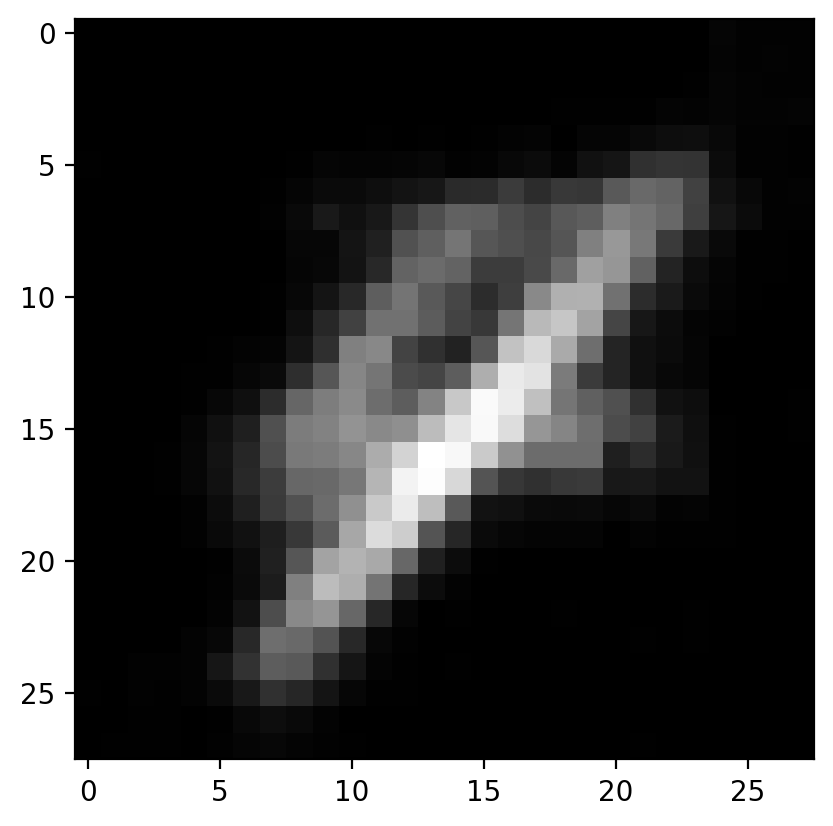

In [ ]:
x1 = vae.sample(1)
plt.imshow(x1[0].permute(1,2,0), cmap='gray')
plt.show()


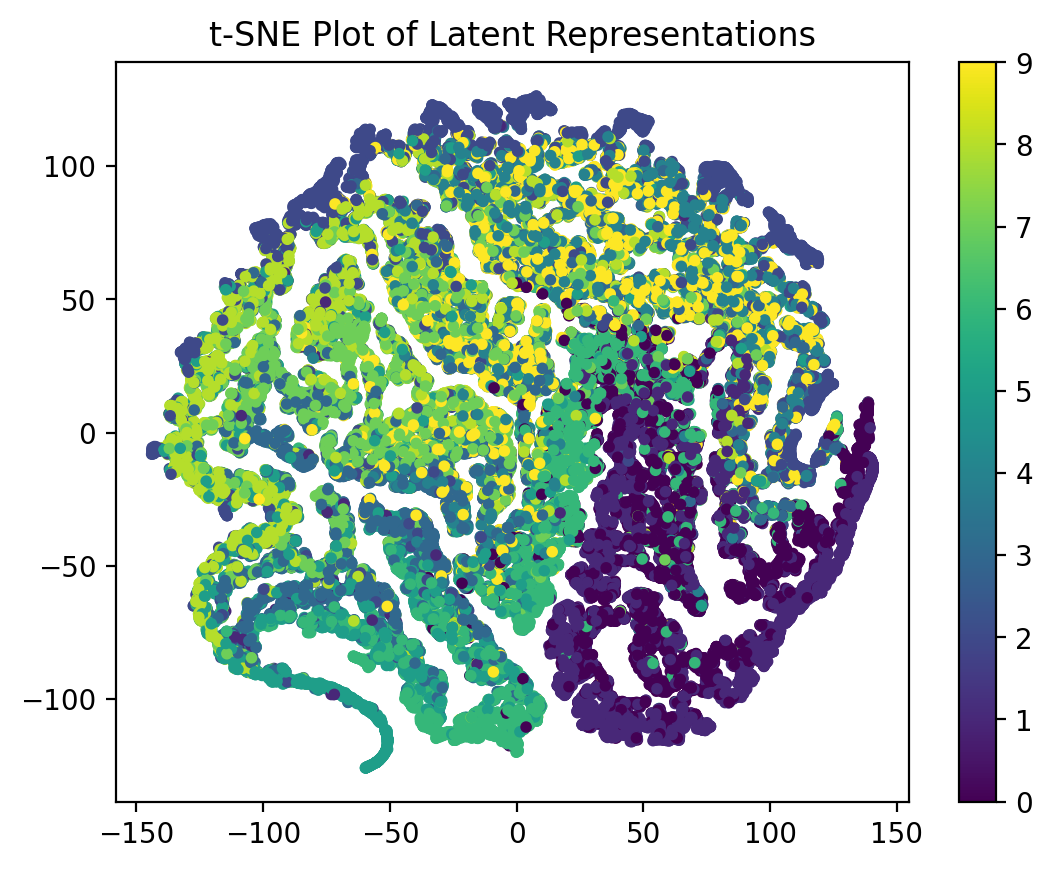

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming you have a trained VAE model (vae) and a DataLoader (dataloader)

# Set the model to evaluation mode
vae.eval()

# Lists to store latent representations and corresponding labels
reconst = []
labels = []

# Loop through the dataset and obtain latent representations
with torch.no_grad():
    for images, labels_batch in dataloader:
        images_mnist = images
        images_mnist = images_mnist.to(vae.device)
        _, mu_z, _ = vae.encoder.encode_and_sample(images_mnist)
        reconst.append(mu_z.cpu().numpy())
        labels.append(labels_batch.cpu().numpy())

# Concatenate lists to obtain a single array
reconst = np.concatenate(reconst, axis=0)
labels = np.concatenate(labels, axis=0)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(reconst)

# Plot the t-SNE representation
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('t-SNE Plot of Latent Representations')
plt.colorbar()
plt.show()


## Interpolation

In [ ]:
i,l = next(iter(dataloader))


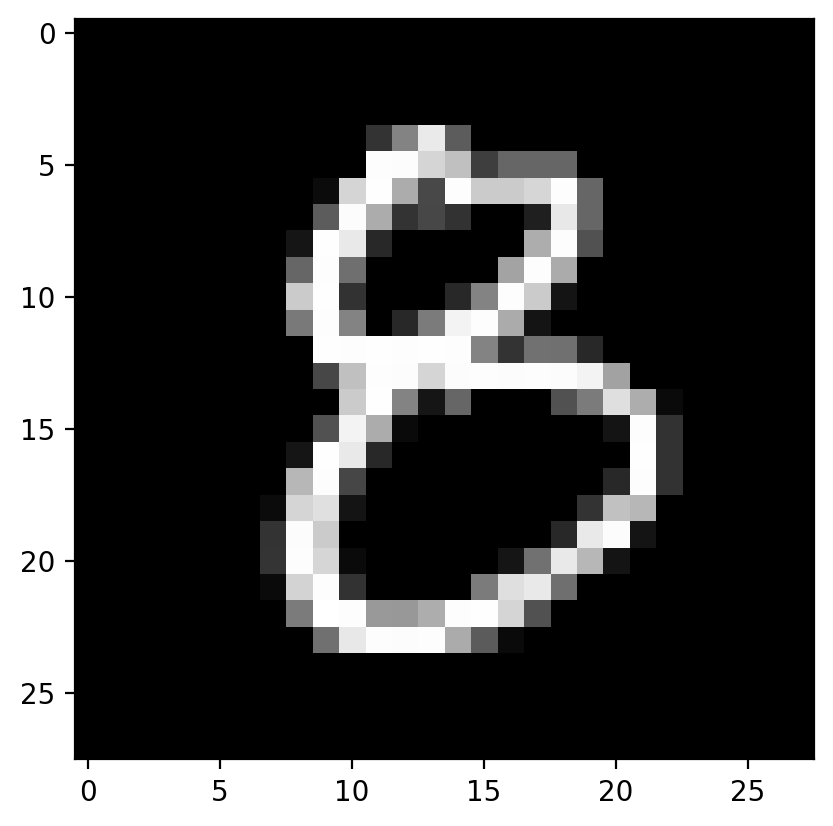

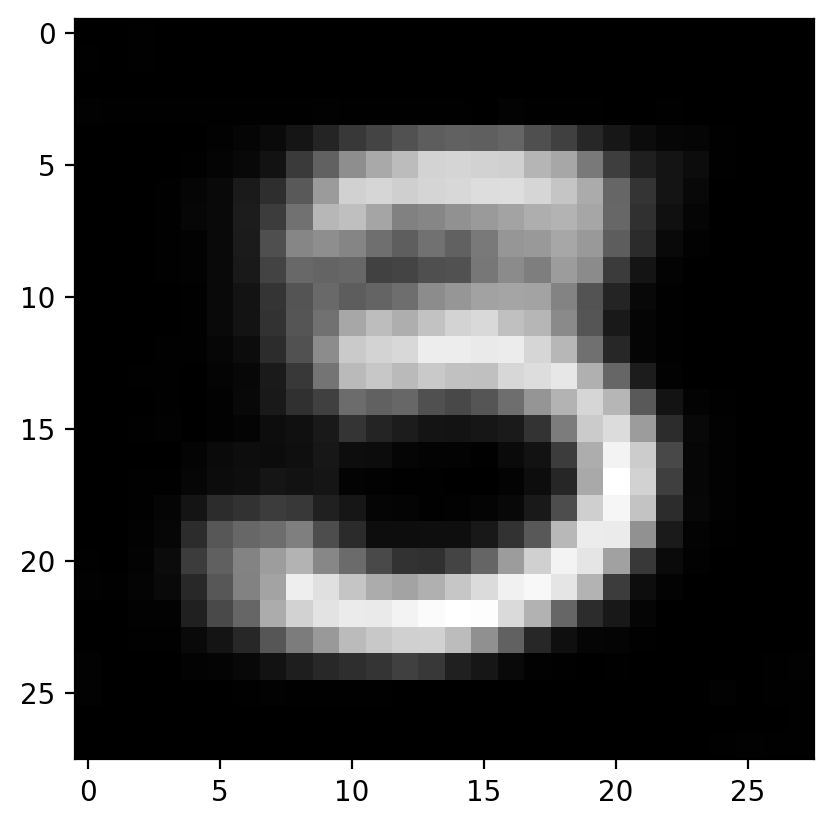

In [ ]:
z_batch,_,_ = vae.encoder.encode_and_sample(x1=i.to(vae.device),flag_sample=False) # YOUR CODE HERE

x_reconstructed = vae.decoder.decode(z_batch).detach() # YOUR CODE HERE

plt.imshow(i[0,:,:,:].to('cpu').permute(1,2,0), cmap='gray')
plt.show()
plt.imshow(x_reconstructed[0,:,:,:].to('cpu').permute(1,2,0), cmap='gray')
plt.show()


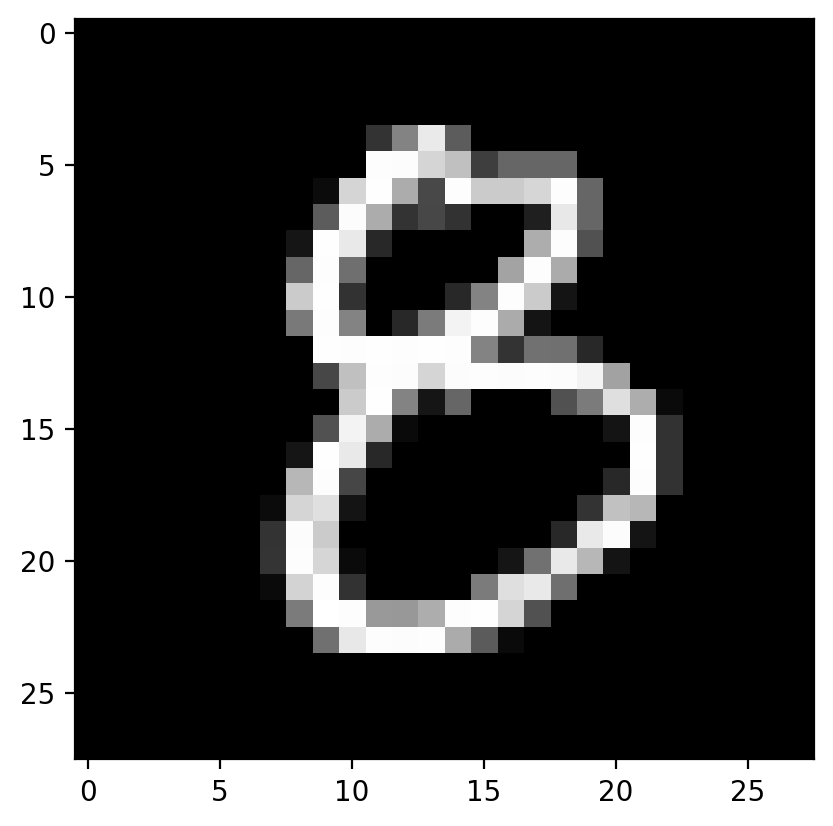

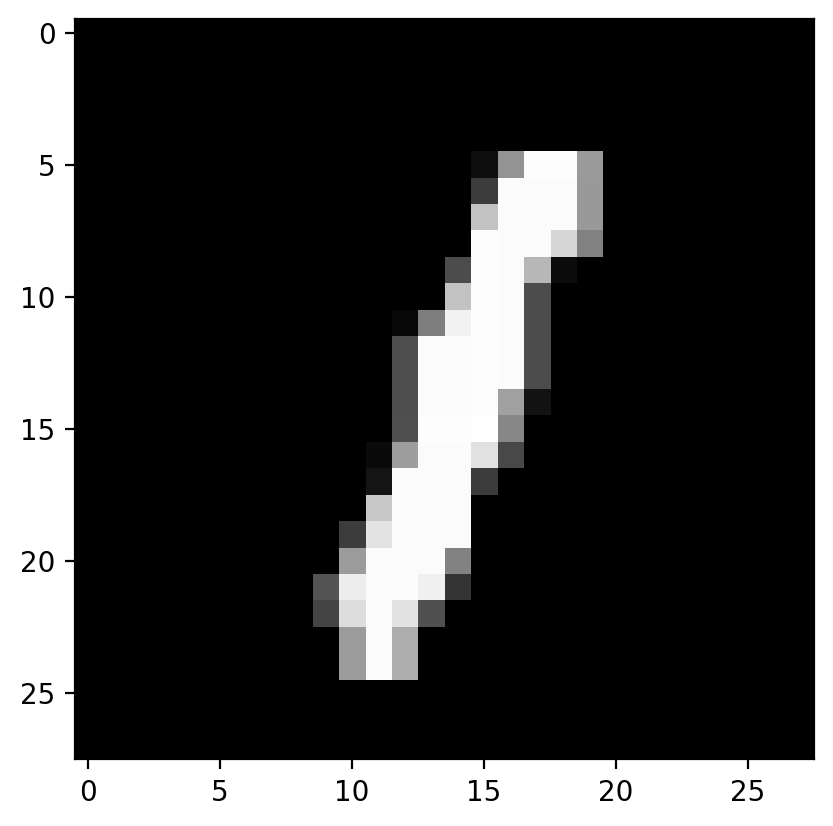

In [ ]:
# Lets visualize the images to interpolate

img_1 = i[0,:,:,:].permute(1,2,0)
img_2 = i[1,:,:,:].permute(1,2,0)

plt.imshow(img_1, cmap='gray')
plt.show()
plt.imshow(img_2, cmap='gray')
plt.show()


In [ ]:
# z_1 and z_2 are saved in z_batch, computed in the previous exercise

z_1 = z_batch[0,:] #YOUR CODE HERE
z_2 = z_batch[1,:] #YOUR CODE HERE

# Linear interpolation

weight = torch.Tensor(1.0-np.arange(0,10,1)/10)

reconstructed_image = [vae.decoder.decode(z_1*w+z_2*(1-w)).to('cpu').detach() for w in weight]

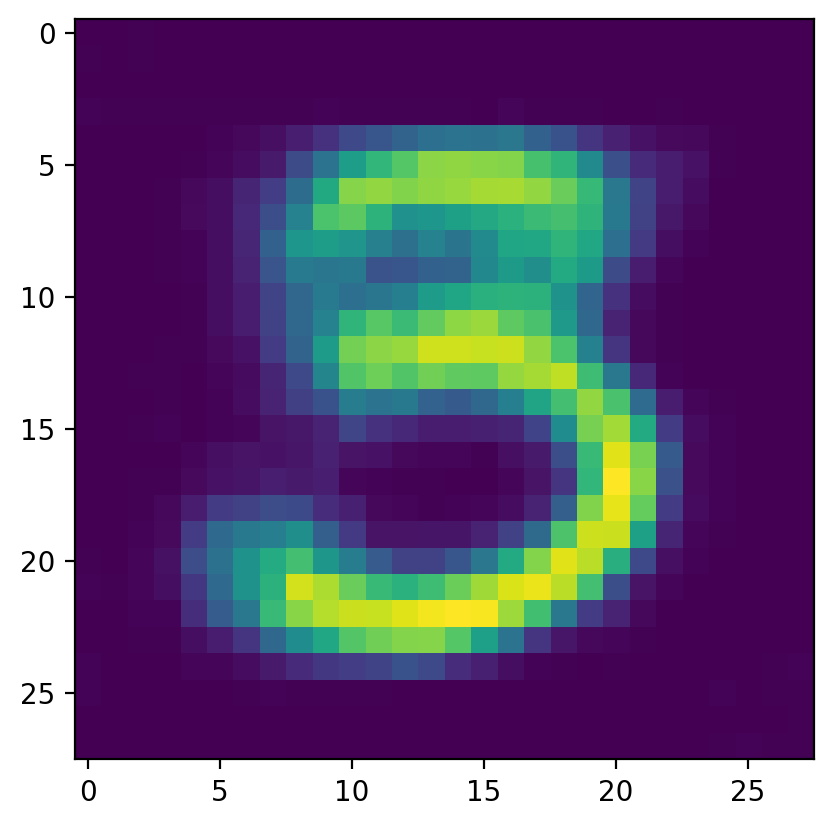

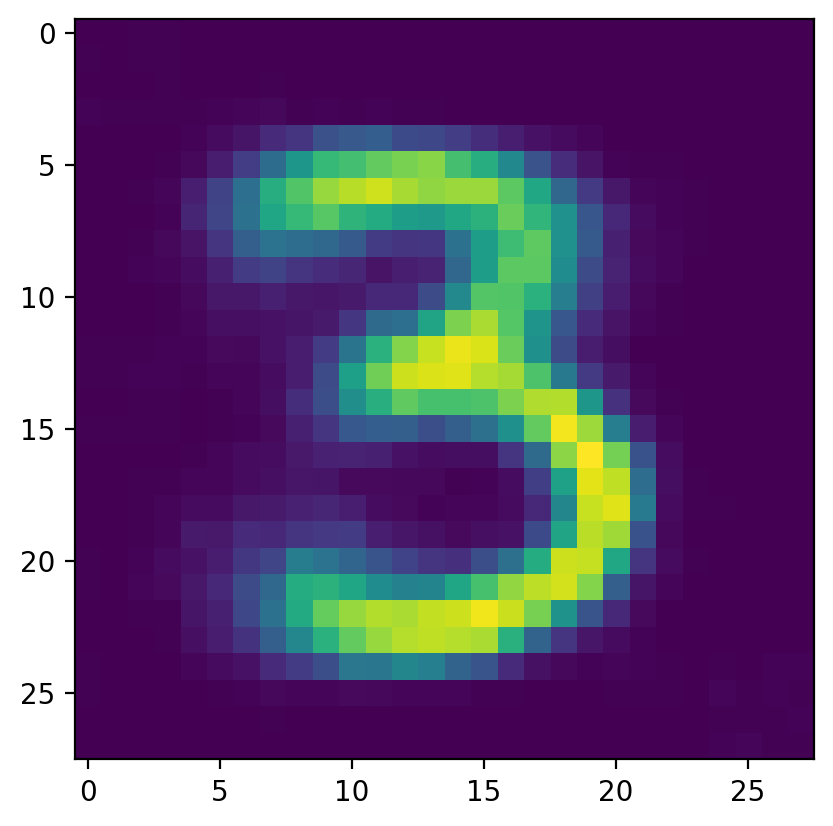

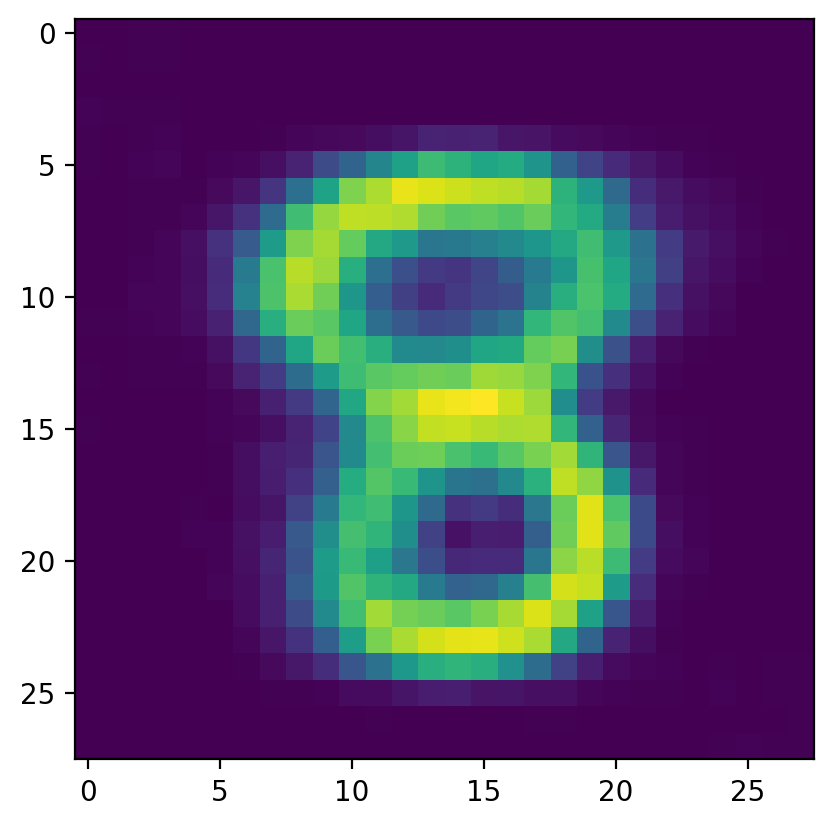

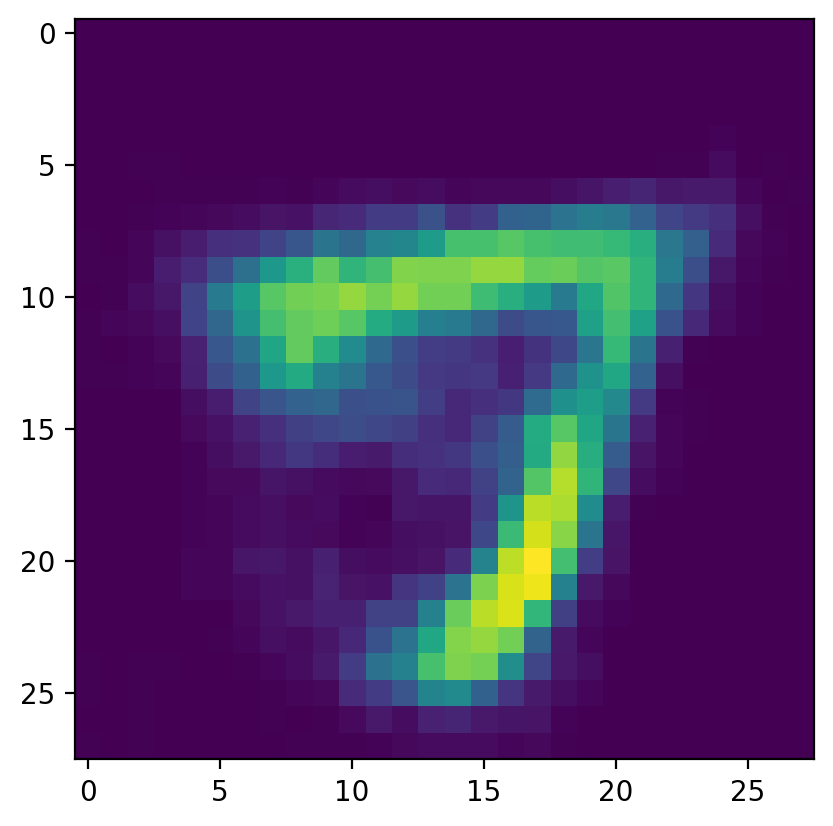

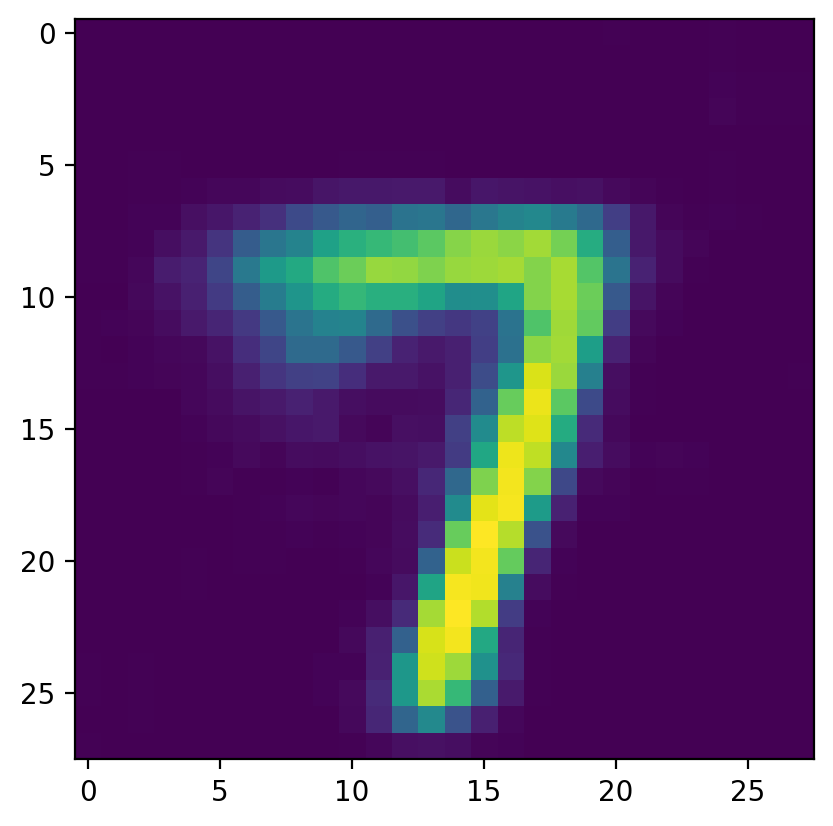

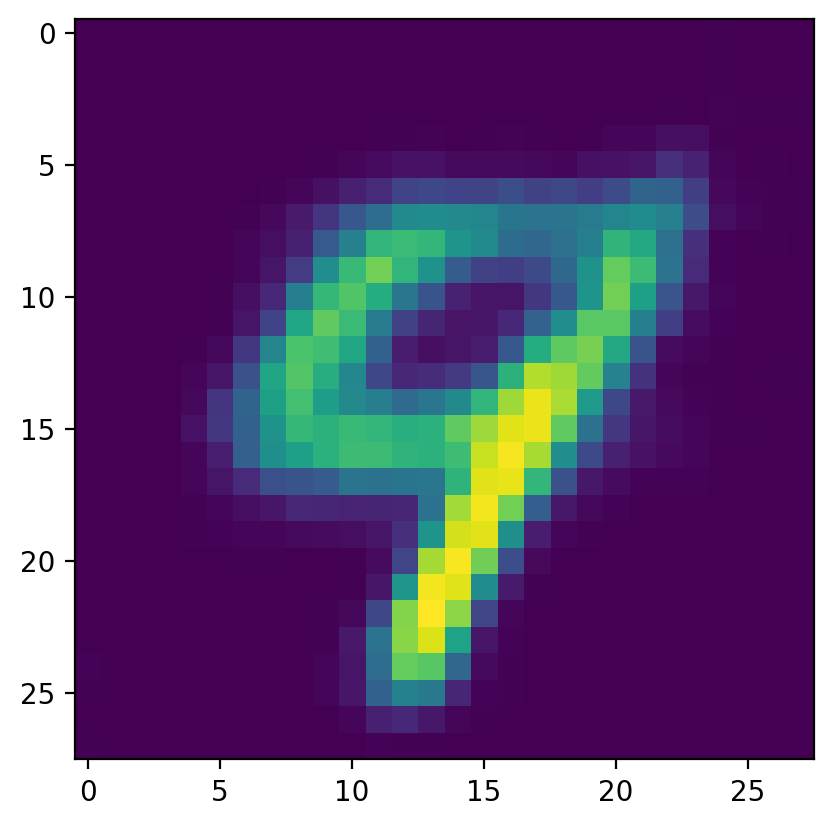

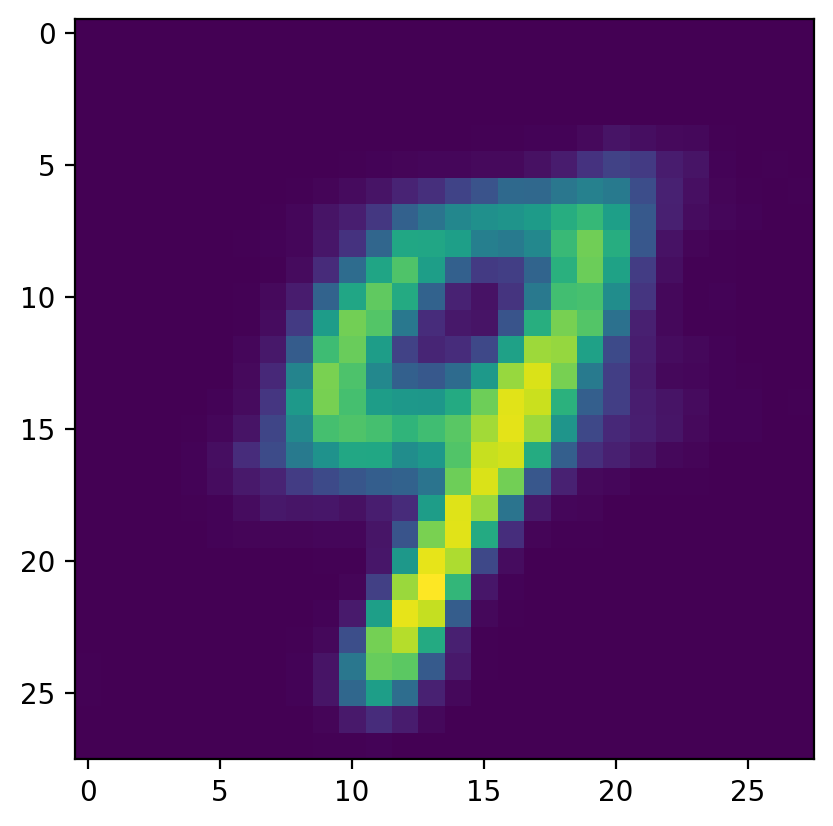

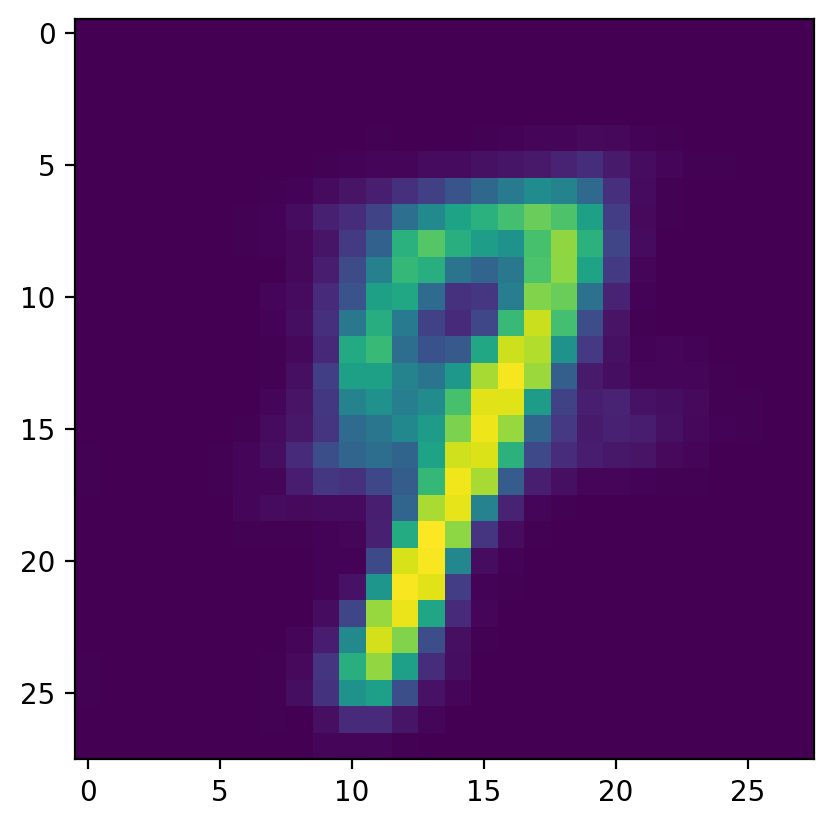

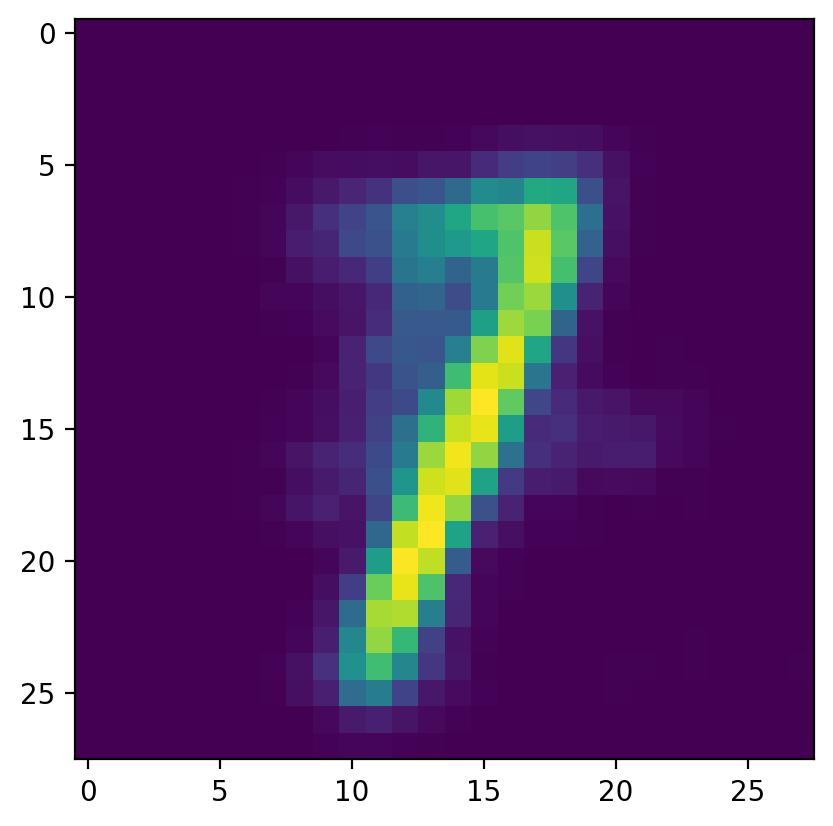

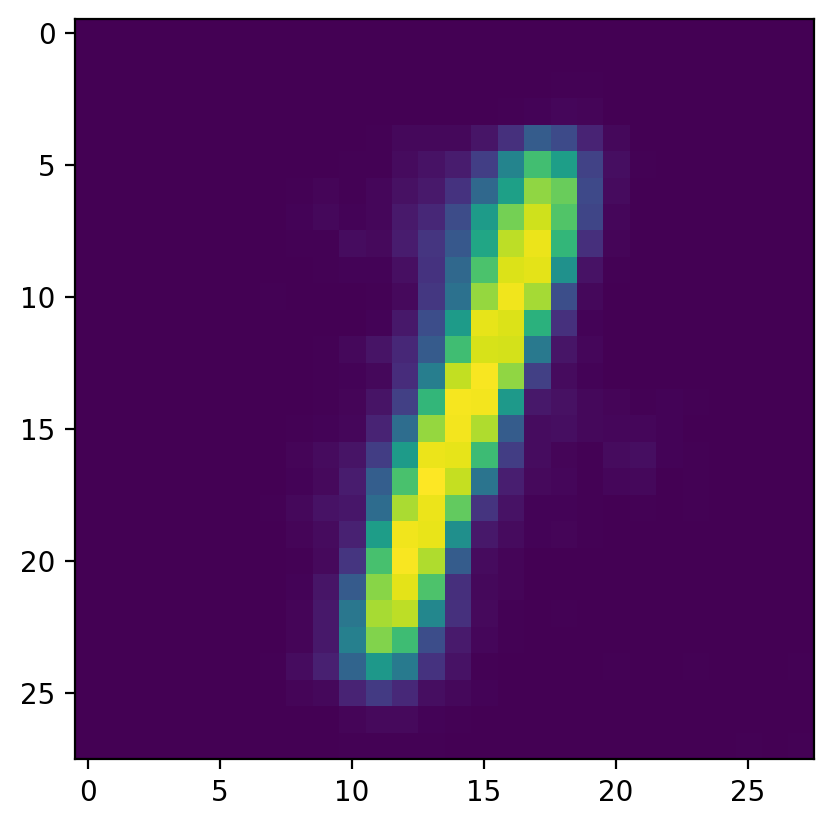

In [ ]:
# Visualize all images in the reconstructed_image list

for im in reconstructed_image:
  plt.imshow(im[0,:,:,:].permute(1,2,0)) #YOUR CODE HERE
  plt.show()